In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1920,
        'height': 1080,
        'scroll': True,
})

{'width': 1920, 'height': 1080, 'scroll': True}

# Week 02, ASTR 596: Fundamentals of Data Science

### Gautham Narayan 
##### <gsn@illinois.edu>


##### With contributions totally ripped of from Zjelko Ivezic and Mario Juric (UW), Gordon Richards (Drexel), Federica Bianco (U. Del) and Maria Suveges (EPFL)



## Recap

* We've done an overview of "descriptive" statistics (as opposed to inferential statistics)
* Random variables (discrete and continuous), sample estimators, covariance
    * Bayes' rule and how it follows from the axioms of probability
    * conditional probability, marginalization

* Distributions (univariate and multivariate), moments, common distributions, PDFs, CDFs
* Random variables as samples from a distribution 
* Why you should look at the samples, not just moments/summary statistics
* Comparing samples to a normal distribution (the QQ plot), identifying skewness, outliers

* The central limit theorem
* Basic visualizations of multivariate data
* Dealing with basic astronomical data types

### <center> Remember the goal is to get to <i>P(H|D).</i> </center>

### <center> What questions do you have? </center>

## The Method of Moments and Hypothesis Testing 


### The Method of Moments (Chebyshev, 1887)
We know how to estimate moments if we have an underlying description of the population - the PDF

### <center> $\mu_{n} = \int_{-\infty}^{\infty} (x-c)^{n} \cdot p(x) \cdot dx $ </center>

Generally, we do not have the PDF but have some random samples that are drawn from it.

We have been equating sample moments with population moments already

* the KDE plot with multivariate data
* estimating parameters from a multivariate sample by eye and constructing a multivariate Gaussian
* your homework...

This works when the data is simple enough to be described by some simple model. You also know when this isn't the case:

<img src="./figures/DataDino-600x455.gif" width="200">

But if it is the case...

* Assume a form for the empirical PDF $f(x; \theta)$
* Equate the sample moments with the empirical moments

In [2]:
# here's a quick demo of the method of moments works with some simulated data
# the process we're simulating is a Poisson process
# The statistics of sources that you detect with devices like CCDs that count photons will follow a Poisson process
# Remember from Week 1 that astronomers don't report measurements in number of photons detected
# or number of counts measured more accurately
# but rather they take -2.5*log_10(counts) and add a constant to scale
# Also remember that if you have a Poisson process with mean lambda, then the variance is also lambda
# so the standard deviation is the sqrt of lambda 


# RUN THIS CELL
%pylab
%matplotlib inline
import scipy.stats as st
from astropy.visualization import hist as ahist
import statsmodels.api as sm

# you can change this number and execute the cell below 
samp_size = 1000

# and this number
true_flux = 2000

# simulate something like the magnitudes you might measure on a detector
samp = -2.5*np.log10(st.poisson.rvs(true_flux, size=samp_size)) + 25

# true moments are straightforward - remember change of variables for the standard deviation
mu_true = -2.5*np.log10(true_flux) + 25
sig_true = np.log10(e)*2.5*np.sqrt(true_flux)/true_flux

# sample moments are also easy 
mu_samp = samp.mean()
sig_samp = samp.std()

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


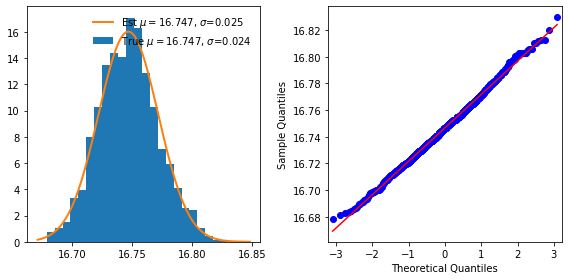

In [3]:
fig = figure(figsize=(8, 4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# let's histogram the sample we have 
ahist(samp, bins='freedman', density=True, ax=ax1,\
      label=fr'True $\mu=${mu_true:.3f}, $\sigma$={sig_true:.3f}')
xmin, xmax = ax1.get_xlim()
xval = np.arange(xmin, xmax+0.01, 0.001)

# and overplot the PDF we estimate using the method of moments
estpdf  = st.norm.pdf(xval, loc=mu_samp, scale=sig_samp)
ax1.plot(xval, estpdf, color='C1', lw=2, label=fr'Est $\mu=${mu_samp:.3f}, $\sigma$={sig_samp:.3f}')
ax1.legend(frameon=False)

# we know that in the limit of large lambda, the Poisson process should look like a Gaussian process
sm.qqplot(samp, line='r', ax=ax2)
tight_layout()

This is closely related to the **Null Hypothesis Rejection Test** (NHRT)

* You have data drawn from some unknown population
* Assume a model for that population
    * This allows you to make a prediction for the data you have
    * "Under the null hypothesis" = if the model is a good description of the data
        * then the data should be highly probable
    * Define a test such that some observation has a very low probability of happening

* Given your data, if the low probability happened, then you can reject your model
* If it hasn't happened, your model still holds
    * but that doesn't tell you it's a good description of the data

<center> <img src='./figures/nhrt.png'> </center>
(credit: Federica Bianco, U. Delaware)

So when you hear "$x$ is a 2-$\sigma$ detection!"

* 2-$\sigma$: confidence level
* 0.05: p-value
* 95%: threshold


Unstated here is that there is an assumption of some model, typically a Gaussian.

**Nothing** here states that the model is a good description of the data at all.

Consider this from Kang et al. "Early-type Host Galaxies of Type Ia Supernovae. II. Evidence for Luminosity Evolution in Supernova Cosmology", 2020, ApJ, 889, Issue 1, id. 8

[ADS Link](https://ui.adsabs.harvard.edu/abs/2020ApJ...889....8K/abstract)
or 
[ArXiv](https://arxiv.org/abs/1912.04903)

  <center> <img src ="./figures/kang_sne_evol.png" width="800"> </center>

### Staistical sins

- hypotheses suggested by non-representative data
    - you almost always have to deal with this in real data
- looking for patterns in your data is legitimate
    - applying a hypothesis test to the same data from which a pattern emerges is not
        - randomized out-of-sample tests/cross-validation
- p is not the probability that the hypothesis is false! (remember what you are given here is the hypothesis)
- p-hacking: only reporting the hypothesis with a significant p-value but not reporting the ones without

#### Read Cohen 1994 "The Earth is Round (p < .05)" included in the directory for all the issues with hypothesis testing
    

If your sample is indeed drawn from a random distribution:

### <center> $ \left| x - \mu \right| > 3\sigma$ implies $X$ is more extreme than the distribution 0.27% of the time </center>

## In class exercise 1
### NRHT when the model isn't normal

The Universe has many processes that throw outliers into your nice curated data
(I hope you are enjoying your homework)

If you model a sample as normal, but the underlying population isn't then you are liable to flag something as significant when it isn't. 

See what difference it makes when you go from a Gaussian to a Student's t-distribution with 8 degrees of freedom:

Total probability of being between +/- 3 sigma for N(0,1) 0.9973002039367398
Therefore probability of being a 3 sigma outlier for N(0,1) 0.002699796063260207
Total probability of being between +/- 3 sigma for t8 0.9829283187662174
Therefore probability of being a 3 sigma outlier for t8 0.017071681233782554
0.997 probability intervals for N(0,1) (-2.999976992703389, 2.9999769927034015)
0.997 probability intervals for t8 (-4.276576799570991, 4.276576799571021)


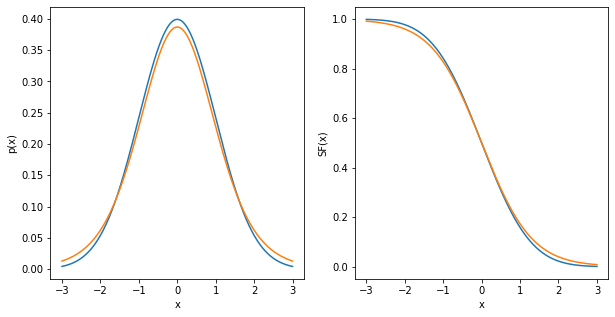

In [4]:
# You can evaluate what P(X > x) is with the survival function i.e. (1 -  CDF(X))
fig = figure(figsize=(10, 5))
x = np.arange(-3, 3.01, 0.01)
pdf = st.norm.pdf(x)
sf = st.norm.sf(x)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(x, pdf)
ax2.plot(x, sf)

ax1.set_xlabel('x')
ax1.set_ylabel('p(x)')

ax2.set_xlabel('x')
ax2.set_ylabel('SF(x)')

# DO THIS FOR A T-DISTRIBUTION WITH Nu=8
# your code goes here
pdf2 = st.t.pdf(x, 8)
sf2 = st.t.sf(x, 8)

ax1.plot(x, pdf2, color='C1')
ax2.plot(x, sf2, color='C1')

# If you have just a few samples, you might not be able to tell that your data is t-distributed
# rather than normally distributed - the PDFs are pretty similar
# but if you look at the tails of the distribution, the t-clearly has more outliers

# whereas for a Normal distribution 3 sigma corresponds to 99.7% of the data
print("Total probability of being between +/- 3 sigma for N(0,1)", st.norm.cdf(3) - st.norm.cdf(-3))
print("Therefore probability of being a 3 sigma outlier for N(0,1)" , 1- (st.norm.cdf(3) - st.norm.cdf(-3)))
print("Total probability of being between +/- 3 sigma for t8", st.t.cdf(3, 8) - st.t.cdf(-3, 8))
print("Therefore probability of being a 3 sigma outlier for t8" , 1- (st.t.cdf(3, 8) - st.t.cdf(-3, 8)))

# i.e. an order of magnitude more likely to get an outlier with a t8.


# another thing you can try is the interval function to ask what interval encloses % of the total probability
# this is better for assymetric distributions
print("0.997 probability intervals for N(0,1)", st.norm.interval(0.9973))
print("0.997 probability intervals for t8", st.t.interval(0.9973, 8))

The issue with the method of moments and classical hypothesis testing is they are not very **robust** to outliers in the data.

Particularly if the outlier fraction is significant relative to the total sample size.

In [5]:
# Run this cell 

samp_size = 200

# you can control the outlier fraction
outlier_fraction1 = 0.1
outlier_fraction2 = 0.05

# simulate something like the magnitudes you might measure on a detector
samp1 = -2.5*np.log10(st.poisson.rvs(2000, size=samp_size)) + 25

# except now we're going to add a small distribution on the wings - if this was magnitudes
# maybe this is a second fainter source in a close binary
samp2 = -2.5*np.log10(st.poisson.rvs(1850, size=max(int(outlier_fraction1*samp_size), 1))) + 25

# and we'll add some large, easy to see outliers - these might be cosmic rays
samp3 = -2.5*np.log10(st.poisson.rvs(3700, size=max(int(outlier_fraction2*samp_size), 1))) + 25

# let's combine all three samples together
samp = np.concatenate((samp1, samp2, samp3), axis=-1)

# and shuffle our measurements, so you can't do outlier rejection 4
# by simply clipping the first/last N elements of the array
np.random.shuffle(samp)

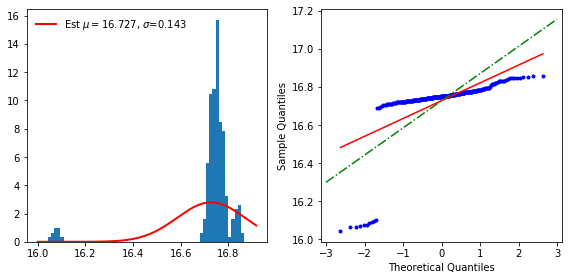

In [6]:
# sample moments
mu_samp = samp.mean()
sig_samp = samp.std()

fig = figure(figsize=(8, 4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# histogram the sample 
ahist(samp, bins='freedman', density=True, ax=ax1)
xmin, xmax = ax1.get_xlim()
xval = np.arange(xmin, xmax+0.01, 0.001)

# plot the methods of moments estimator assuming a normal distribtuion
estpdf  = st.norm.pdf(xval, loc=mu_samp, scale=sig_samp)
ax1.plot(xval, estpdf, color='r', lw=2, label=fr'Est $\mu=${mu_samp:.3f}, $\sigma$={sig_samp:.3f}')
ax1.legend(frameon=False)

# and make a QQ plot of the sample 
sm.qqplot(samp, line='r', ax=ax2, marker='.')

# note that all the regression line (i.e. the line = "r" option is doing) above is doing
# is computing the sample mean and standard deviation
# and plotting Y = mean + sigma*X

# you can verify this by plotting the same line yourself
qq = np.arange(-3, 3, 0.01)
y = mu_samp + sig_samp*qq
ax2.plot(qq, y, 'g-.')


# this is cosmetic and just tidies up the plot
tight_layout()

## In class exercise 2
### Robust Statistics - Alternative 1: Eliminating Outliers (i.e. clean your data)

In your homework, you have encountered one way to cleanup your data, using the QQ-plot.
* using a line defined through some quartiles
* using $Y = \mu + \sigma\cdot x$ 

Both of these methods are fundamentally assuming the data is normally distributed.

astropy.stats has a sigma_clip method that also assumes the data is normally distributed, but you can control around where. In particular you can use the median.

Try eliminating the outliers with it, and check if the method of moments estimator gives you something reasonable.

Done


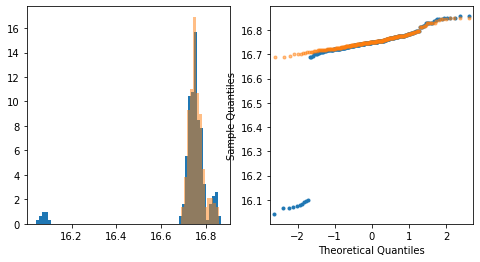

In [7]:
from astropy.stats import sigma_clip
# your code goes here - don't overwrite samp

# you can change the threshold for sigma clipping - note that sigma is fairly large 
# with the methods of moments estimator, so you might have to make this small 

# the method is a bit ad hoc because of this threshold that you can tune
# at 4-5 sigma, you may not see much of an effect at all
# at 2-3 sigma, you might be clipping useful data
clipped_samp = sigma_clip(samp, sigma=3, stdfunc='std', masked=False)

fig = figure(figsize=(8, 4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# plot the sample and the sigma-clipped sample
ahist(samp, bins='freedman', density=True, ax=ax1)
ahist(clipped_samp, bins='freedman', density=True, ax=ax1, color='C1', alpha=0.5)

# and the QQ plots
sm.qqplot(samp, marker='.', color='C0', ax=ax2)
sm.qqplot(clipped_samp, marker='.', color='C1', ax=ax2, alpha=0.5)

print("Done") # this is just to suppress Jupyter from making two plots 

$\sigma$-clipping is probably the most widely used outlier rejection method in the astronomy literature.

However it is *ad hoc* - $\sigma$ itself is changing each clipping iteration, but you cannot know how unless you know the underlying PDF that the sample was drawn from, including the outliers.

It's also painfully slow with large quantities of data. 

## Alternative 2: L-estimators

It's useful to have some summary statistics that describe distributions, which are robust to outliers, and can be computed fast.

We assumed a form for the empirical PDF $f(x; \theta)$, and used some moments as estimators. But there are other quantities that you can get from the empirical PDF that are more robust. 

The quantile estimators we looked at in week 1 already have this behavior.

### $$ p = \int_{-\infty}^{x_p} f(x) dx $$

### and the median: $$ \frac{1}{2} = \int_{-\infty}^{x_{\frac{1}{2}} } f(x) dx $$

You can also define measures of the variance of the data. This was one - you've used it on your homework implicitly.

### <center> $ \text{IQR} = x_{\frac{3}{4}} - x_{\frac{1}{4}} $</center>

For a normal distribution, $\sigma = \text{IQR}/2\sqrt{2}\cdot\text{erf}^{-1}(\frac{1}{2}) \;\; (\approx1.349)$. This is another common L-estimator called the **Median Absolute Deviation**

### <center> $ \text{MAD}  = \left| x_i - x_{\frac{1}{2}} \right| $ </center>

For a normal distribution, $\sigma = 1.4826\cdot\text{MAD}$


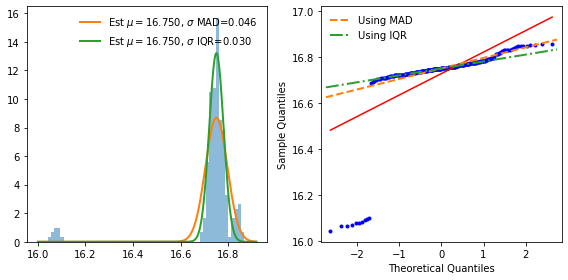

In [8]:
# if we repeat the exercise with robust estimators

# these are just the robust estimators we discussed above in functional form
# you can write your own functions from scratch if you like, but scipy.stats already has them
# you should remember how to call MAD at least - it'll be something you use a lot
median = np.median(samp)
sig_robust = 1.4826*st.median_absolute_deviation(samp)
sig_robust2 = st.iqr(samp)/1.349


# same sort of plots we've been making
fig = figure(figsize=(8, 4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# sample
ahist(samp, bins='freedman', density=True, ax=ax1, alpha=0.5)
xmin, xmax = ax1.get_xlim()
xval = np.arange(xmin, xmax+0.01, 0.001)

# this time, instead of applying the method of moments using the sample moments, we're using the L-estimators
estpdf  = st.norm.pdf(xval, loc=median, scale=sig_robust)
estpdf2  = st.norm.pdf(xval, loc=median, scale=sig_robust2)

# overplot the estimated PDFs
ax1.plot(xval, estpdf, color='C1', lw=2, label=fr'Est $\mu=${median:.3f}, $\sigma$ MAD={sig_robust:.3f}')
ax1.plot(xval, estpdf2, color='C2', lw=2, label=fr'Est $\mu=${median:.3f}, $\sigma$ IQR={sig_robust2:.3f}')
ax1.legend(frameon=False)

# and the QQ plot
sm.qqplot(samp, line='r', ax=ax2, marker='.')

# and the trend lines
nmin, nmax = ax2.get_xlim()
nvals = np.arange(nmin, nmax+0.01, 0.01)
y = median + sig_robust*nvals
y2 = median + sig_robust2*nvals
ax2.plot(nvals, y, '--', color='C1', lw=2, label='Using MAD')
ax2.plot(nvals, y2, '-.', color='C2', lw=2, label='Using IQR')


ax2.legend(frameon=False)
tight_layout()

L-estimators work well when:
   * the data has outliers
   * the data has no (or at least very small) uncertainties associated with it
       * notice that we computed them from the sample, but made no mention/use of sample uncertainties

## Alternative 3: M-estimators

* As before, assume a form for the empirical PDF $f(x; \theta)$
* Define a **loss function** $\rho(u)$ for some quantity $u$ e.g. $x - \mu$
* Minimize this loss over the sample
    * $\sum_{i=1}^{N} \rho(u_i) $ 

### OK, so what the heck is a loss function now?

If $(x_1, x_2..., x_N)$ is a set of i.i.d random variables from some distribution p(x) which we don't know, but want to estimate. 

What we're trying to do is to build an estimator for moments out of the sample.

If we define

## <center> $ \rho(x, \theta=\mu) = \frac{(x - \mu)^2}{2} $ </center>

How do you go about minimizing this with respect to $\theta$?

For $u = x-\mu$, there's several potential cost functions:

## <center> $\rho(u) = u^2$ </center>
    
is an old friend to all of you. It's the **sum of squared residuals** or what we sometimes call the $L_2$ norm.

Of the loss functions, this is the nicest behaved - it's **convex** and **differentiable**

### In class exercise

Let's use the sum of least squares M-estimator to evaluate the mean of our sample in the previous section

If you are starting here on Thursday, make sure you execute previous cells in the notebook (might be easiest to "Restart and Run All" from the Kernel menu)

In [9]:
# first we need to define a the loss function that returns the sum of squared residuals for some value of theta=mu

def sum_of_squared_residuals(mu):
        """
        This is a simple sum of squared residuals function
        """
        # samp is in the Namespace for this function
        # we could make a more general function by passing the data in as an argument

        residual = samp - mu
        return np.sum(residual**2.)

In [10]:
# next lets evaluate this function over the range of the sample
# there are numerical ways to do this, but we'll brute force it


# we'll create a grid of points in x and evaluate the loss function at each position
# we can get the limits from the plot in the previous section
xmin, xmax = ax1.get_xlim()
x_grid = np.arange(xmin, xmax, 0.01)

# and then we want to evaluate the loss function
ssr = [sum_of_squared_residuals(x) for x in x_grid]

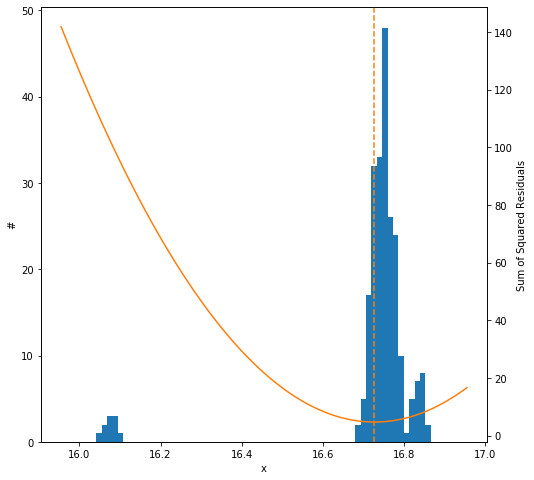

In [23]:
# finally histogram the sample and overplot the loss function and sample

# the sample is easy - we've done that a bunch already
fig = figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ahist(samp, ax=ax1, bins="freedman")
ax1.set_xlabel('x')
ax1.set_ylabel('#')

# if you have a matplotlib axis, you can create a twin axis with the same x axis but a different y axis with
ax2 = ax1.twinx()
ax2.set_ylabel('Sum of Squared Residuals')

# Now plot the loss function you evaluated as a function of x - use a different color than the default
# YOUR CODE GOES HERE:
ssr = np.array(ssr)
ax2.plot(x_grid, ssr, color='C1')

# find the minimum of the LOSS FUNCTION and plot a vertical line at the location of the minimum
# use the came color as above
# YOUR CODE GOES HERE:

mu_M = x_grid[ssr.argmin()]
ax2.axvline(mu_M, color='C1', linestyle='--')

**Differentiability implies continuity. Continuity does not guarantee differentiability.**

Most M-estimators aren't nicely differentiable, but often have other properties - such as resistance to outliers.

You've already seen another loss function:

### <center> $\rho(u) = \left|u \right|$ </center>

This is the sum of absolute residuals and is related directly to the MAD. You might see it called the $L_1$ norm, particularly in machine learning literature. 

### Other loss functions you'll see

<center> <img src="./figures/loss_functions.jpg"> </center>

### M-estimators and The Likelihood Function

If we know the distribution from which our data were drawn (or make a hypothesis about it), then we can compute the **probability** of our data being generated.

For example, for the Gaussian distribution probablity of getting a specific value of $x$ is given by:

## $$p(x|\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right).$$

### The Likelihood Function

If we want to know the total probability of our *entire* data set (as opposed to one measurement) then we must compute the *product* of all the individual probabilities:

## $$L \equiv p(\{x_i\}|H(\theta)) = \prod_{i=1}^n p(x_i|H(\theta)),$$

where $H$ refers to the *hypothesis* and $\theta$ refers collectively to the $k$ parameters of the model, which can generally be multi-dimensional. 


In words, this is ***the probability of the data given the model parameters***. 

Note that this implicitly assumes that the measurements in your sample are, as always, i.i.d


Recall (from the axioms of probability) that:

## $$ P(A \cap B)  = P(A|B)\cdot P(B) = P(B|A)\cdot P(A)$$
and iff:
## $$ P(A \cap B) = P(A) \cdot P(B) $$ then $A$ and $B$ are **independent**.



We can write this out as:
### $$L = \prod_{i=1}^n \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right),$$

This can simplify to
### $$L = \left( \prod_{i=1}^n \frac{1}{\sigma\sqrt{2\pi}} \right) \exp\left( -\frac{1}{2} \sum \left[\frac{-(x_i-\mu)}{\sigma} \right]^2 \right),$$

where we have written the product of the exponentials as the exponential of the sum of the arguments, which will make things easier to deal with later.

i.e. we have done this: 
### $$\prod_{i=1}^n A_i \exp(-B_i) = (A_iA_{i+1}\ldots A_n) \exp[-(B_i+B_{i+1}+\ldots+B_n)]$$

The argument of the exponential is just

### $$\exp \left(-\frac{\chi^2}{2}\right).$$

where, for our Gaussian distribution
### $$\chi^2 = \sum_{i=1}^n \left ( \frac{x_i-\mu}{\sigma}\right)^2.$$

At some specific values of the model parameters, $\theta$, we can evaluate the likelihood of our data, given the model (you did this with the sum of squared residuals) i.e 

### $$p(D | \theta)$$

**Note**

For multidimensional distributions, as we will see later in the course, the uncertainties come in the form of a covariance matrix where there uncertainties can be correlated. This still assumes Gaussianity

## $$ L = p(D\; | \;  \pmb \theta\;) =  \prod_{k=1}^{n} \; \frac{1}{(2\pi)^{d/2} \; |\Sigma|^{1/2}} exp \bigg[ -\frac{1}{2}(\pmb x - \pmb \mu)^t \Sigma^{-1}(\pmb x - \pmb \mu) \bigg]$$

where $\Sigma$ is the covariance matrix and $d$ is the dimensionality

For practical reasons, it's better to work with the natural logarithm of the likelihood (we'll get to why in a few slides)

We define the *log-likelihood function* as ${\rm lnL} = \ln[L(\theta)]$.  The maximum of this function happens at the same place as the maximum of $L$. Given all that, we have:

## $${\rm lnL} = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma^2}.$$

We then determine the maximum in the same way that we always do.  It is the parameter set for which the derivative of ${\rm lnL}$ is zero:

$$\frac{d\;{\rm lnL}(\mu)}{d\mu}\Biggr\rvert_{\hat \mu} \equiv 0.$$

That gives $$ \sum_{i=1}^N \frac{(x_i - \hat \mu)}{\sigma^2} = 0.$$

(note: we should also check that the $2^{\rm nd}$ derivative is negative, to ensure this is the *maximum* of $L$)

(also note: any constants in $\ln L$ disappear when differentiated, so constant terms can typically be ignored.)

So, maximizing the likelihood is the same as minimizing $\chi^2$:

Maximizing the likelihood is solving for the extremum of:
### $$ L \sim \exp \left(-\frac{\chi^2}{2}\right).$$

is the same as Maximizing the natural logarithm of the likelihood:
(because the log is a monotonically increasing function)

### $$ \ln (L) \sim -\frac{\chi^2}{2}$$

and therefore is the same as **minimizing** the negative log likelihood:

### $$ -\ln(L) \sim \frac{\chi^2}{2}$$


i.e. maximum likelihood estimation - and $\chi^2$ minimization are just a special case of M-estimators. 

Since $\sigma = {\rm constant}$, that says 
## $$\sum_{i=1}^N x_i = \sum_{i=1}^N \hat \mu = N \hat \mu.$$

Thus we find that
## $$\hat \mu = \frac{1}{N}\sum_{i=1}^N x_i,$$
which is just the arithmetic mean of all the measurements.

## This is how we started the week with the method of moments.


### The Sample Mean is an ML Estimator

The mean of observations drawn from a $N(\mu, \sigma=const)$ distribution is a maximum-likelihood estimator of the distribution's $\mu$ parameter.

We'd used this and guessed this intuitively, but this derivation clarifies our choice: as an estimator of the real value of $\mu$, we adopt the value $\hat \mu$ with which it's maximally likely for the measured data set to occur.

It also exposes the ***assumptions*** behind this conclusion; namely homoscedasticity and gaussianity of uncertainties. For example, if our uncertainties were Cauchy-distributed the mean (or any higher moment) is not define

## The Core Idea Behind Maximum Likelihood Estimators

Let's say that we know that some data were drawn from a Gaussian distribution, but we don't know the $\theta = (\mu,\sigma)$ values of that distribution (i.e., the parameters).

Then Maximum Likelihood Estimation method tells us to think of the likelihood as a ***function of the unknown model parameters***, and ***find those that maximize the value of $L$***. Those will be our Maximum Likelihood Estimators for for the true values of the model.

**NOTE**

The Likelihood function is the joint **probability density** of all measurements. 

For each measurment we have a probablity density. These probability densities have **units**. 

They are the reciprical of the units of the measurement (as the integrated probability does not have units but the interval over which we are integrating does).

You will generally see people minimizing the negative log likelihood rather than maximizing the likelihood directly

The reason is fairly simple:

While the components of $L$ may be normalized pdfs, their *product* is not. 

The PDFs often yield verys small numbers, which you are then multiplying together, making even smaller numbers.

### $$10^{-24}$$ is pretty small

### $$ \log_{10}(10^{-24}) = -24$$ is not!

### Properties of ML Estimators

Assuming the data truly are drawn from the model, ML estimators have the following useful properties:

* **They are consistent estimators**; that is, they can be proven to converge to the true parameter value as the number of data points increases.

* **They are asymptotically normal estimators**. The distribution of the parameter estimate, as the number of data points increases to infinity, approaches a normal distribution, centered at the MLE, with a certain spread. 

* **This spread can often be easily calculated and used as a confidence band around the estimate**

Estimators (L-, M-, and the special case of MLE) are themselves random variables 

They can only be determined given the data after all and the observations are themselves random variables

So it's reasonable to ask how confident we are in our estimate - what is the uncertainty.

## Quantifying Estimate Uncertainty

We *define* the uncertainty on our MLEs using the second (partial) derivatives of log-likelihood:

## $$\sigma_{jk} = \left( - \frac{d^2}{d\theta_j} \frac{\ln L}{d\theta_k} \Biggr\rvert_{\theta=\hat \theta}\right)^{-1/2}.$$

Taken together, these entries (more accurately, their squares) are know as the **covariance matrix**. We'd defined this in terms on samples from a bivariate distribution last week. Now we're redefining it in terms of the likelihood!

This is also called the **Fisher-information matrix, $I(\theta)$** 

The marginal error bars for each parameter, $\theta_i$ are given by the diagonal elements, $\sigma_{ii}$. These are the "error bars" that are typically quoted with each measurement. Off diagonal elements, $\sigma_{ij}$, arise from any correlation between the parameters in the model.

In our example with Gaussian likelihoods, the uncertainly on the mean is 
## $$\sigma_{\mu} = \left( - \frac{d^2\ln L(\mu)}{d\mu^2}\Biggr\rvert_{\hat \mu}\right)^{-1/2}$$

We find
## $$\frac{d^2\ln L(\mu)}{d\mu^2}\Biggr\rvert_{\hat \mu} = - \sum_{i=1}^N\frac{1}{\sigma^2} = -\frac{N}{\sigma^2},$$
since, again, $\sigma = {\rm constant}$.  

Then 
## $$\sigma_{\mu} = \frac{\sigma}{\sqrt{N}}.$$

So, our estimator of $\mu$ is $\overline{x}\pm\frac{\sigma}{\sqrt{N}}$, which is a result that you should be familiar with.

### Connecting Uncertainty back to Geometry

OK, so we're happy with the second derivative of the log likelihood at the MLE looking like an uncertainty for a Gaussian.


But it's reasonable to ask why this works for any general likelihood function?

The result for $\sigma_{\mu}$ has been derived by expanding $\ln L$ in a Taylor series and retaining terms up to second order (essentially, $\ln L$ is approximated by a parabola, or an ellipsoidal surface in multidimensional cases, around its maximum).

If this expansion is exact (as is the case for a Gaussian error distribution), then we've completely captured the error information.

In general, this is not the case and the likelihood surface can significantly deviate from a smooth elliptical surface. 

Furthermore, it often happens in practice that the likelihood surface is multimodal. 

It is always a good idea to visualize the likelihood surface when in doubt.

### i.e. LOOK AT YOUR DATA

### The Cramer-Rao bound

If you have an unbiased estimator of a parameter $T(\theta)$, such as a ML estimator with a large number of samples, this estimator has a minimum possible uncertainty.

That variance of the estimator is bounded by 

## $$ \text{Var}(T(\theta)) \geq \frac{1}{I(\theta)} $$

where $I(\theta)$ is the Fisher information matrix.

### This is why the Fisher information is used in error analysis

* If you have an estimate of the likelihood (assuming some model) of the data, you can compute the maximum.

* If you can compute the maximum, you can also compute how the likelihood changes near the maximum, approximating it with a parabola/n-dimensional ellipsoid.

* This lets you compute the Fisher information.

* The Cramer-Rao bound says that this is the best case you can do if your estimator is unbiased. 

* If your estimator actually attains this limit, it is said to be *efficient*

## Goodness of Fit

The MLE approach tells us what the "best" model parameters are, but not how good the fit actually is.  
(You already know the MLE estimate can be poor if there are outliers).

If the model is wrong, "best" might not be particularly revealing!  

We can describe the **goodness of fit** as whether or not it is likely to have obtained $\ln L_0$ by randomly drawing from the data.  That means that we need to know the *distribution* of $\ln L$. 

## Goodness of Fit

For the Gaussian case, we can write

### $$z_i = (x_i-\mu)/\sigma,$$ 
then
### $$\ln L = {\rm constant} - \frac{1}{2}\sum_{i=1}^N z^2 = {\rm constant} - \frac{1}{2}\chi^2.$$

So **$\ln L$ is distributed as $\chi^2$ (with $N-k$ degrees of freedom).**

## Goodness of Fit


The expectation value for the $\chi^2$ distribution is $N − k$ and its standard deviation is $\sqrt{2(N − k)}$. We typically have $N \gg k$ (where $N$ is the number of data points, and $k$ is the number of parameters in the model). When that holds, it becomes useful to define **$\chi^2$ per degree of freedom, $\chi^2_{dof}$**, as:

## $$\chi^2_{dof} = \frac{1}{N-k}\sum_{i=1}^N z^2_i.$$

Therefore, for a good fit we would expect that $\chi^2_{dof}\approx 1$ (the expectation value).  If $\chi^2_{dof}$ is significantly larger than 1, then it is likely that we are not using the correct model.

We can also get overly high or low values of $\chi^2_{dof}$ if our uncertainties are under- or over-estimated. This is particularly interesting when we have correlated uncertainties


![Ivezic, Figure 4.1](http://www.astroml.org/_images/fig_chi2_eval_1.png)

In [12]:
sigma_clip?

In [13]:
clipped_samp

array([16.74905484, 16.76328344, 16.77046828, 16.73447373, 16.75177666,
       16.76053265, 16.78329758, 16.72805557, 16.76659361, 16.82797024,
       16.73393743, 16.72167512, 16.81460538, 16.78217595, 16.75177666,
       16.73019074, 16.83972711, 16.84803333, 16.74417268, 16.72805557,
       16.84387228, 16.75450533, 16.778818  , 16.78723243, 16.77491347,
       16.70850174, 16.77380047, 16.73931237, 16.74851129, 16.76825249,
       16.72326672, 16.83618666, 16.77380047, 16.75614583, 16.73447373,
       16.73823525, 16.74146982, 16.8510153 , 16.74742501, 16.82738573,
       16.74688228, 16.74255016, 16.7371592 , 16.72752243, 16.75232185,
       16.82972568, 16.75177666, 16.7754704 , 16.76714629, 16.72645694,
       16.72061535, 16.74688228, 16.74742501, 16.77491347, 16.74851129,
       16.74146982, 16.76659361, 16.73931237, 16.75286731, 16.71744222,
       16.75614583, 16.69963428, 16.72061535, 16.74146982, 16.77491347,
       16.7211451 , 16.73179488, 16.73072519, 16.73019074, 16.73

In [15]:
var = sigma_clip(samp, sigma=3, stdfunc='std', masked=True)

In [17]:
var.mask.shape

(230,)

In [18]:
samp.shape

(230,)

In [20]:
samp[~var.mask]

array([16.74905484, 16.76328344, 16.77046828, 16.73447373, 16.75177666,
       16.76053265, 16.78329758, 16.72805557, 16.76659361, 16.82797024,
       16.73393743, 16.72167512, 16.81460538, 16.78217595, 16.75177666,
       16.73019074, 16.83972711, 16.84803333, 16.74417268, 16.72805557,
       16.84387228, 16.75450533, 16.778818  , 16.78723243, 16.77491347,
       16.70850174, 16.77380047, 16.73931237, 16.74851129, 16.76825249,
       16.72326672, 16.83618666, 16.77380047, 16.75614583, 16.73447373,
       16.73823525, 16.74146982, 16.8510153 , 16.74742501, 16.82738573,
       16.74688228, 16.74255016, 16.7371592 , 16.72752243, 16.75232185,
       16.82972568, 16.75177666, 16.7754704 , 16.76714629, 16.72645694,
       16.72061535, 16.74688228, 16.74742501, 16.77491347, 16.74851129,
       16.74146982, 16.76659361, 16.73931237, 16.75286731, 16.71744222,
       16.75614583, 16.69963428, 16.72061535, 16.74146982, 16.77491347,
       16.7211451 , 16.73179488, 16.73072519, 16.73019074, 16.73